### Importar Libs

In [1]:
import os
import subprocess
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report

import mapie
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score

In [2]:
%load_ext watermark

In [3]:
%watermark

Last updated: 2023-09-05T23:21:54.006612-03:00

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.15.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [4]:
%watermark --iversions

numpy     : 1.25.2
re        : 2.2.1
matplotlib: 3.7.2
sklearn   : 1.3.0
pandas    : 2.1.0
mapie     : 0.6.5
seaborn   : 0.12.2



### Variaveis de Ambiente

In [5]:
path_dados = 'DryBeanDataset/'
data = 'Dry_Bean_Dataset.xlsx'

### Importar Dados

In [6]:
df_beans = pd.read_excel(path_dados + data)
df_beans.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178,173.889,1.197,0.550,28715,190.141,0.764,0.989,0.958,0.913,0.007,0.003,0.834,0.999,SEKER
1,28734,638.018,200.525,182.734,1.097,0.412,29172,191.273,0.784,0.985,0.887,0.954,0.007,0.004,0.910,0.998,SEKER
2,29380,624.110,212.826,175.931,1.210,0.563,29690,193.411,0.778,0.990,0.948,0.909,0.007,0.003,0.826,0.999,SEKER
3,30008,645.884,210.558,182.517,1.154,0.499,30724,195.467,0.783,0.977,0.904,0.928,0.007,0.003,0.862,0.994,SEKER
4,30140,620.134,201.848,190.279,1.061,0.334,30417,195.897,0.773,0.991,0.985,0.971,0.007,0.004,0.942,0.999,SEKER


In [7]:
print(df_beans.shape)

(13611, 17)


In [8]:
df_beans.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')

### Pré-Processamento

In [9]:
# Criando Target multiclass
le = LabelEncoder()
y = le.fit_transform(df_beans["Class"])

# Definindo Features
X = df_beans.drop("Class", axis = 1)

print(len(X), len(y))

13611 13611


In [10]:
# Separar Treino/Teste/Calibração
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=10000, random_state=12)
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=1000, random_state=42)
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=1000, random_state=72)

print(len(X_train), len(X_test), len(X_calib))

10000 1000 1000


In [11]:
# Pre Processamento de Texto - Polynomial Features
poly = PolynomialFeatures(degree=2)

### Treinamento do Modelo

In [12]:
pipe_nb = Pipeline([
    ('poly', poly),
    ('nb', GaussianNB())
    ])

pipe_nb

Pipeline(steps=[('poly', PolynomialFeatures()), ('nb', GaussianNB())])

In [13]:
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()), ('nb', GaussianNB())])

### Aplicando o Modelo nas Bases de Treino/Teste/Calibração

In [14]:
y_train_nb_hat = pipe_nb.predict(X_train)
y_test_nb_hat = pipe_nb.predict(X_test)
y_calib_nb_hat = pipe_nb.predict(X_calib)

### Avaliação do Modelo na Base de Teste

Matriz de Confusão:  

Acurácia: 0.631


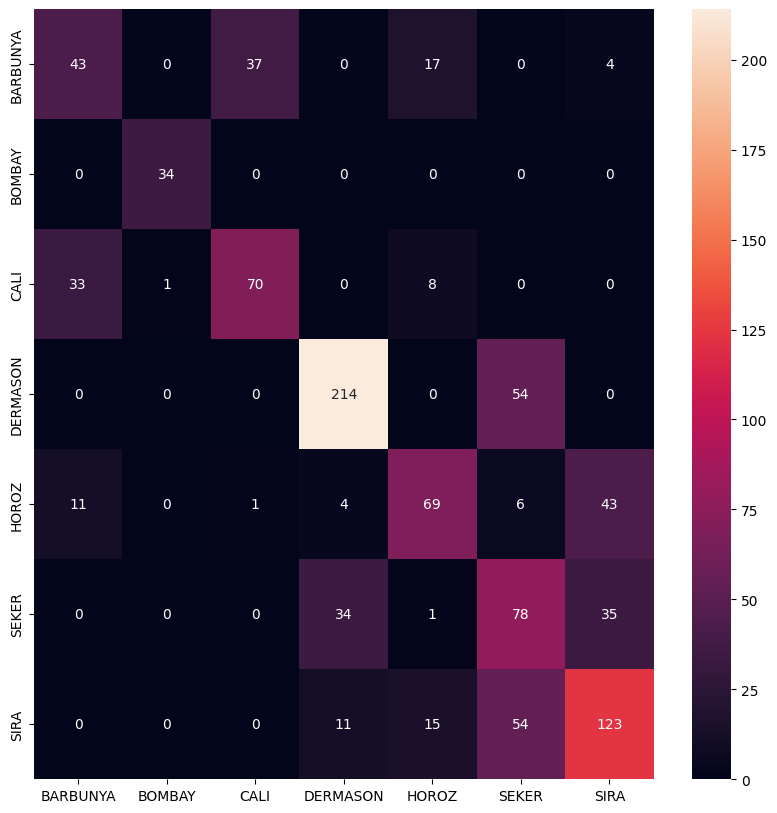

In [15]:
print("Matriz de Confusão:  \n")
print("Acurácia:", (y_test_nb_hat == y_test).mean())
cm = confusion_matrix(y_test, y_test_nb_hat)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.show();

In [16]:
print("Report de Classificação:  \n")
print(classification_report(y_test, y_test_nb_hat, target_names=le.classes_))

Report de Classificação:  

              precision    recall  f1-score   support

    BARBUNYA       0.49      0.43      0.46       101
      BOMBAY       0.97      1.00      0.99        34
        CALI       0.65      0.62      0.64       112
    DERMASON       0.81      0.80      0.81       268
       HOROZ       0.63      0.51      0.57       134
       SEKER       0.41      0.53      0.46       148
        SIRA       0.60      0.61      0.60       203

    accuracy                           0.63      1000
   macro avg       0.65      0.64      0.64      1000
weighted avg       0.64      0.63      0.63      1000



### Verificando a confiabilidade e calibração dos modelos

In [17]:
# Obtenha as "probabilidades" do modelo
y_calib_nb_proba = pipe_nb.predict_proba(X_calib)
# Obtenha para cada instância a maior probabilidade
high_prob_predictions = np.amax(y_calib_nb_proba, axis=1)
# Selecione as previsões onde a probabilidade é superior a 95%
high_p_beans = np.where(high_prob_predictions >= 0.95)
# Vamos contar com que frequência acertamos a label correta
its_a_match = (y_calib == y_calib_nb_hat)
coverage = np.mean(its_a_match[high_p_beans])
print("Cobertura Logistic Regression:  \n")
print(round(coverage, 3))

Cobertura Logistic Regression:  

0.696


Idealmente, 95% ou mais dos filmes deveriam ter a classe prevista, mas infelizmente mesmo filtrando os 95% com maior probabilidades, encontramos 70% de casos corretos.

O que fazer agora?

### Calibração do Modelo com Conformal Prediction

Como obter uma garantia que a cobertura das previsões do modelo caiam em 95% ?

Na Conformal Prediction, utilizamos o Score de Não-Conformidade (𝑠𝑖), que mede o quão incomum um resultado sugerido 𝑦 aparece dado a saída do modelo para 𝑥𝑖. Para decidir quais y são “conformes”, e formar a região de previsão, que é um limite baseado nas pontuações de não-conformidade dos dados de calibração em combinação com as labels verdadeiras.

𝑠𝑖 = 1 — 𝑓(𝑥𝑖)[𝑦𝑖]

Para encontrar esse limite, é feito o seguinte procedimento:

- Comece com dados não usados para treinamento do modelo
- Calcule as pontuações 𝑠𝑖
- Classifique as pontuações de baixa (certa) a alta (incerta)
- Calcule o limite q onde 95% dos 𝑠𝑖 são menores (= 95% quantil)

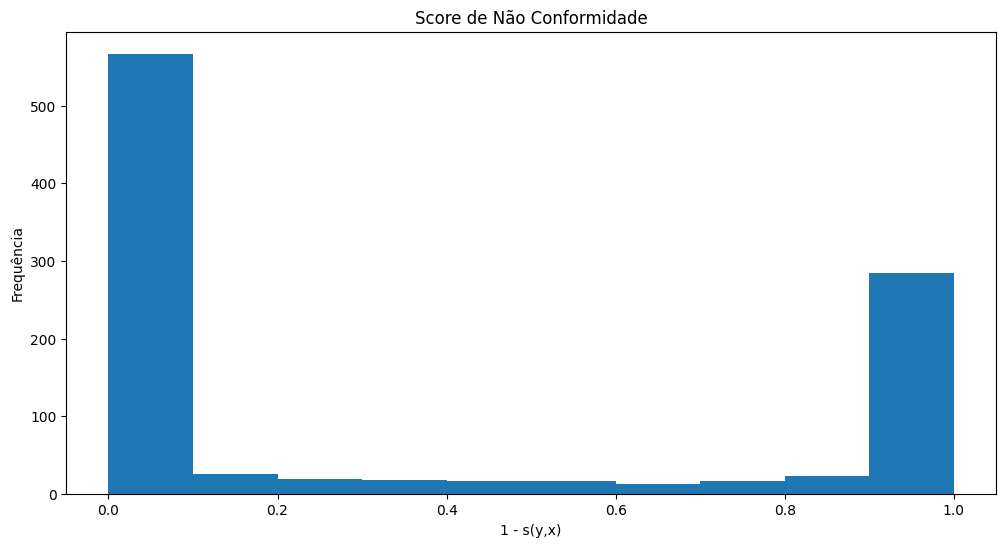

In [18]:
# Tamanho dos Dados de Calibração
n = len(X_calib)
# Obtenha as "probabilidades" do modelo
y_calib_nb_proba = pipe_nb.predict_proba(X_calib)
# Filtrar as probabilidades das classes verdadeiras
prob_true_class = y_calib_nb_proba[np.arange(n), y_calib]
# Transformar em Score de Incerteza (maior significa mais incerto)
scores = 1 - prob_true_class
# Definir o alfa para obter conjuntos de previsões de 95%
alpha = 0.05
# Definir os quantis
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(scores, q_level)

# Crie um histograma
fig, axs = plt.subplots(figsize=(12, 6))
plt.hist(1 - prob_true_class, range=(0, 1))
plt.xlabel("1 - s(y,x)")
plt.ylabel("Frequência")
plt.title("Score de Não Conformidade")
plt.show()

O código acima calcula esses limites e também o ponto de corte.

O nível quantil (baseado em 𝛼) requer uma correção de amostra finita para calcular o quantil correspondente. Nesse caso, o 0,95 foi multiplicado por (n+1)/n , o que significa que 𝑞𝑙𝑒𝑣𝑒𝑙 = 0,951 para n = 1000.

E ao final do código, se visualizarmos as pontuações, veremos que é uma questão de cortar na posição correta, conforme mostrado no histograma acima.

Para incluir a classe certa 95% das vezes, seria necessário cortar tudo acima de 𝑞 = 0,99906.

Mas há um problema: para alguns pontos de dados, haverá mais de uma classe que fará o corte. Mas os conjuntos de previsão não são um bug, eles são um recurso da Previsão Conforme.

Para gerar os conjuntos de previsão para um novo ponto de dados, o cientista de dados deve combinar todas as classes que estão abaixo do limite 𝑞 em um conjunto.

Abaixo, listamos os conjuntos de previsão para 10 “novos” feijões (X_new):

In [19]:
prediction_sets = (1 - pipe_nb.predict_proba(X_new) <= qhat)
for i in range(10):
    print(le.classes_[prediction_sets[i]])

['DERMASON' 'SEKER' 'SIRA']
['DERMASON' 'SEKER' 'SIRA']
['DERMASON']
['DERMASON' 'SEKER']
['DERMASON' 'SEKER']
['SEKER' 'SIRA']
['BARBUNYA' 'CALI']
['DERMASON']
['SEKER' 'SIRA']
['DERMASON' 'SEKER' 'SIRA']


Em média, os conjuntos de previsão cobrem a verdadeira classe com uma probabilidade de 95%. Essa é a garantia que obtemos do procedimento conforme.

Como a empresa de feijão poderia trabalhar com tais conjuntos de previsões ? O primeiro conjunto tem 3 variedades de feijão. Já os feijões #3 e #8 tem um conjunto de previsões da variedade Dermason. Enquanto que alguns possuem 2 variedades.

### Calibração do Modelo com Conformal Prediction - Usando a lib MAPIE (Método "Ingênuo")

In [20]:
# Inicializar o MapieClassifier
mapie_score = MapieClassifier(pipe_nb, cv="prefit", method="naive")
# Passo de Calibração
mapie_score.fit(X_train, y_train)
# Passo de Previsão
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05)
# Remover o conjunto fora da tolerância (alpha)
y_set = np.squeeze(y_set)

Para os 5 primeiros conjuntos de previsões para os feijões, abaixo vemos que são de tamanho 1 ou 2.

In [21]:
y_set = np.squeeze(y_set)

for i in range(10):
    print(le.classes_[y_set[i]])

['SEKER']
['SEKER']
['DERMASON']
['DERMASON']
['DERMASON']
['SIRA']
['CALI']
['DERMASON']
['SEKER' 'SIRA']
['SEKER']


Observando os demais feijões em X_new, a maioria dos conjuntos tem tamanho 1 e a minoria têm 2 variedades.

In [22]:
# Contagem do número de classes por feijão
set_sizes = y_set.sum(axis=1)

# Calcular com que frequência cada tamanho ocorre
print(pd.Series(set_sizes).value_counts())

1    1241
2     370
Name: count, dtype: int64


Isso parece diferente se tornarmos 𝛼 pequeno, dizendo que queremos uma alta probabilidade de que a classe verdadeira esteja lá.

In [23]:
y_pred, y_set = mapie_score.predict(X_new, alpha=0.01)
y_set = np.squeeze(y_set)

# Contagem do número de classes por feijão
set_sizes = y_set.sum(axis=1)

# Calcular com que frequência cada tamanho ocorre
print(pd.Series(set_sizes).value_counts())

1    1018
2     590
3       3
Name: count, dtype: int64


Como esperado, obtemos conjuntos maiores com um valor menor para 𝛼. Isso ocorre porque quanto menor o 𝛼, mais frequentemente os conjuntos precisam cobrir o parâmetro verdadeiro. Então já podemos ver que existe um trade-off entre o tamanho do conjunto e a cobertura.

In [24]:
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05)
y_set = np.squeeze(y_set)

cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Cobertura (Coverage) com alpha de 95%: {:.2%}'.format(cov))
print('Tamanho Médio do Conjunto com alpha de 95%: {:.2f}'.format(setsize))

y_pred, y_set = mapie_score.predict(X_new, alpha=0.01)
y_set = np.squeeze(y_set)

cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Cobertura (Coverage) com alpha de 99%: {:.2%}'.format(cov))
print('Tamanho Médio do Conjunto com alpha de 99%: {:.2f}'.format(setsize))

Cobertura (Coverage) com alpha de 95%: 76.04%
Tamanho Médio do Conjunto com alpha de 95%: 1.23
Cobertura (Coverage) com alpha de 99%: 81.13%
Tamanho Médio do Conjunto com alpha de 99%: 1.37


### Calibração do Modelo com Conformal Prediction - Usando a lib MAPIE (Método Score)

O método “score” segue a receita de Previsão Conforme padrão. Começamos com as etapas de treinamento e calibração:

Divida os dados em treinamento e calibração (tamanho 𝑛𝑐𝑎𝑙)
Treine o modelo nos dados de treinamento
Calcular pontuações de não conformidade
– Calcular previsões 𝑓(𝑥) para os dados de calibração
– Manter apenas as probabilidades para as classes verdadeiras 𝑓(𝑥𝑖)[𝑦𝑖]
– Calcular os scores de não conformidade 𝑠𝑖 = 1 − 𝑓(𝑥 𝑖)[𝑦𝑖]

O nível do quantil é 1 − 𝛼 multiplicado por (𝑛𝑐𝑎𝑙 + 1)/𝑛𝑐𝑎𝑙, que serve como um termo de correção de amostra finita. O termo só é relevante quando o conjunto de dados de calibração é pequeno. A título de exemplo, se 𝛼 = 0,05 e 𝑛𝑐𝑎𝑙 = 50, então 𝑞𝑙𝑒𝑣𝑒𝑙 = 0,97. Se 𝑛𝑐𝑎𝑙 = 1000, então 𝑞𝑙𝑒𝑣𝑒𝑙 = 0,951.

In [25]:
mapie_score = MapieClassifier(pipe_nb, cv='prefit', method='score')
mapie_score.fit(X_calib, y_calib)
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05)
y_set = np.squeeze(y_set)

cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Cobertura (Coverage) com alpha de 95%: {:.2%}'.format(cov))
print('Tamanho Médio do Conjunto com alpha de 95%: {:.2f}'.format(setsize))

Cobertura (Coverage) com alpha de 95%: 95.53%
Tamanho Médio do Conjunto com alpha de 95%: 2.03


A cobertura agora é boa, dado 𝛼 = 0,05, o que implica uma cobertura de 95% para os conjuntos de previsão. O tamanho médio do conjunto também é bem pequeno, o que é bom.

### Calibração do Modelo com Conformal Prediction - Cobertura Marginal x Cobertura Condicional

Embora todos os métodos de predição conforme garantam cobertura marginal, o método score não é adaptável à dificuldade de cada classificação. Não temos garantia de que a cobertura seja 1 − 𝛼 para cada ponto de dados, nem mesmo para grupos nos dados, como para cada classe.

Por exemplo, talvez um tipo de feijão seja muito mais difícil de classificar do que outro. Então pode ser que a cobertura para uma classe seja maior que 1−𝛼 e para a outra seja menor, mas em média a cobertura é 1 − 𝛼 (cobertura marginal alcançada).

Se você deseja que o previsor conforme também alcance a garantia de cobertura para grupos de dados, ou mesmo para qualquer ponto no espaço de features, falamos de cobertura condicional.

- Cobertura Marginal: significa que, em média, 1−𝛼 das regiões previstas contêm o rótulo verdadeiro para novas amostras de dados. Todos os preditores conformes garantem cobertura marginal. A cobertura marginal pode ser estimada como a porcentagem de conjuntos de previsão que cobrem a verdadeira classe para um novo conjunto de dados (que pode ser trocado com o conjunto de calibração).

- Cobertura Condicional: significa que a cobertura de 1 − 𝛼 não é apenas verdadeira em média, mas também condicional a algum tipo de agrupamento dos dados. A cobertura condicional perfeita (dividida para cada ponto de dados) não pode ser garantida, apenas tentada. Já obter cobertura condicional para grupos definidos é possível.

In [27]:
def class_wise_performance(y_new, y_set, classes):
    df = pd.DataFrame()
    # Loop through the classes
    for i in range(len(classes)):  
        # Calculate the coverage and set size for the current class
        ynew = y_new[y_new == i]
        yscore = y_set[y_new == i]
        cov = classification_coverage_score(ynew, yscore)
        size = classification_mean_width_score(yscore)
        # Create a new dataframe with the calculated values
        temp_df = pd.DataFrame({
            "class": [classes[i]],
            "coverage": [cov],
            "avg. set size": [size]
            }, index = [i])
        # Concatenate the new dataframe with the existing one
        df = pd.concat([df, temp_df])
    return(df)

# We can apply this function to our new data and the corresponding prediction sets
print(class_wise_performance(y_new, y_set, le.classes_))

      class  coverage  avg. set size
0  BARBUNYA     0.966          2.247
1    BOMBAY     1.000          1.000
2      CALI     0.961          2.157
3  DERMASON     0.958          1.625
4     HOROZ     0.905          2.104
5     SEKER     0.973          2.416
6      SIRA     0.955          2.314


A variedade de feijão “Barbunya” tem a menor cobertura com cerca de 92,53%. Em suma, não parece tão ruim, mas é claro que isso pode mudar sempre que um novo modelo for treinado.

Já os feijões “Bombay” tem uma cobertura de 100%, e isso ocorre pois, se olharmos a matriz de confusão, essa variedade foi a mais fácil de classificar.

# ----------------------------------------------------------------